In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

In [2]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

import joblib

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

In [3]:
# from kaggle.api.kaggle_api_extended import KaggleApi
# import zipfile


# os.environ['KAGGLE_CONFIG_DIR'] = os.path.join(os.getcwd(), 'kaggle')
# api = KaggleApi()
# api.authenticate()


# api.dataset_download_files('arhamrumi/amazon-product-reviews', path='.', unzip=True)


# with zipfile.ZipFile('amazon-product-reviews.zip', 'r') as zip_ref:
#     zip_ref.extractall('amazon_reviews')

In [4]:
df = pd.read_csv("amazon_reviews/Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [6]:
df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [7]:
df.describe(include='all')

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
count,568454.000000,568454,568454,568428,568454.000000,568454.00000,568454.000000,5.684540e+05,568427,568454
unique,NaN,74258,256059,218415,NaN,NaN,NaN,NaN,295742,393579
top,NaN,B007JFMH8M,A3OXHLG6DIBRW8,"C. F. Hill ""CFH""",NaN,NaN,NaN,NaN,Delicious!,"This review will make me sound really stupid, ..."
freq,NaN,913,448,451,NaN,NaN,NaN,NaN,2462,199
mean,284227.500000,NaN,NaN,NaN,1.743817,2.22881,4.183199,1.296257e+09,NaN,NaN
std,164098.679298,NaN,NaN,NaN,7.636513,8.28974,1.310436,4.804331e+07,NaN,NaN
min,1.000000,NaN,NaN,NaN,0.000000,0.00000,1.000000,9.393408e+08,NaN,NaN
25%,142114.250000,NaN,NaN,NaN,0.000000,0.00000,4.000000,1.271290e+09,NaN,NaN
50%,284227.500000,NaN,NaN,NaN,0.000000,1.00000,5.000000,1.311120e+09,NaN,NaN
75%,426340.750000,NaN,NaN,NaN,2.000000,2.00000,5.000000,1.332720e+09,NaN,NaN


### 🔍 Step 1: Dataset Overview

We begin by loading the raw Amazon product reviews dataset, which includes metadata such as:

- `ProductId`, `UserId`
- `Score` (rating)
- `Summary` and full `Text` of the review
- Timestamps (in Unix format)

This dataset will form the foundation for our return risk prediction pipeline.

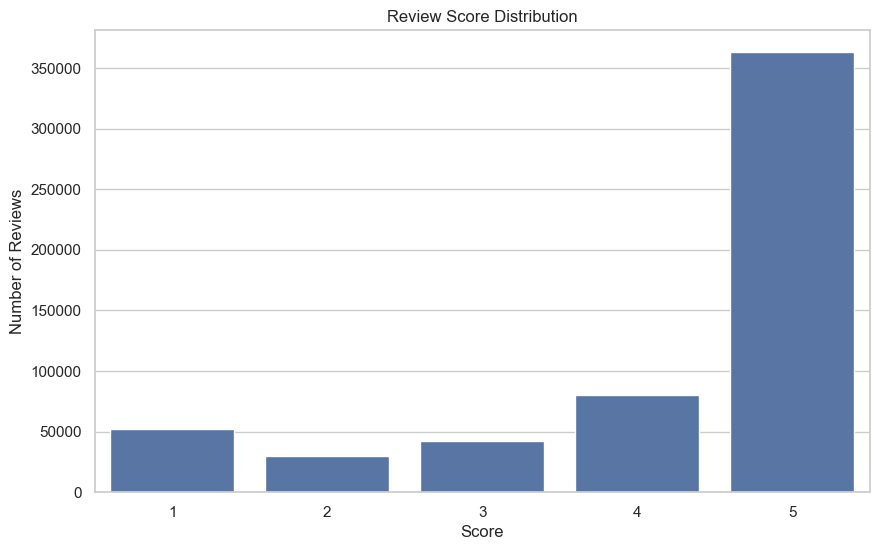

In [8]:
sns.countplot(x='Score', data=df)
plt.title("Review Score Distribution")
plt.xlabel("Score")
plt.ylabel("Number of Reviews")
plt.show()

In [9]:
def map_sentiment(score):
    if score >= 4:
        return "positive"
    elif score == 3:
        return "neutral"
    else:
        return "negative"

df['Sentiment'] = df['Score'].apply(map_sentiment)
df['Sentiment'].value_counts()

Sentiment
positive    443777
negative     82037
neutral      42640
Name: count, dtype: int64

Data Cleaning and Preprocessing

In [ ]:
cols_to_keep = ['ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
                'Score', 'Time', 'Summary', 'Text']
df = df[cols_to_keep]
df.dropna(subset=['Summary', 'Text'], inplace=True)

# Convert Unix time to datetime
df['review_date'] = pd.to_datetime(df['Time'], unit='s')

# Simulate delivery_time in days (1–10)
np.random.seed(42)
df['delivery_time'] = np.random.randint(1, 10, size=len(df))


df['category'] = df['ProductId'].astype(str).str[0]
le = LabelEncoder()
df['category_encoded'] = le.fit_transform(df['category'])


df['review_polarity'] = df['Text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Normalize
scaler = StandardScaler()
df[['delivery_time_scaled', 'review_polarity_scaled']] = scaler.fit_transform(
    df[['delivery_time', 'review_polarity']]
)

df.head()


,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,review_date,delivery_time,category,category_encoded,review_polarity,delivery_time_scaled,review_polarity_scaled
0,B001E4KFG0,A3SGXH7AUHU8GW,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27,7,B,5,0.450000,0.776875,0.927011
1,B00813GRG4,A1D87F6ZCVE5NK,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,4,B,5,-0.033333,-0.385917,-1.222923
2,B000LQOCH0,ABXLMWJIXXAIN,1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18,8,B,5,0.133571,1.164472,-0.480507
3,B000UA0QIQ,A395BORC6FGVXV,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,2011-06-13,5,B,5,0.166667,0.001680,-0.333295
4,B006K2ZZ7K,A1UQRSCLF8GW1T,0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,2012-10-21,7,B,5,0.483333,0.776875,1.075283


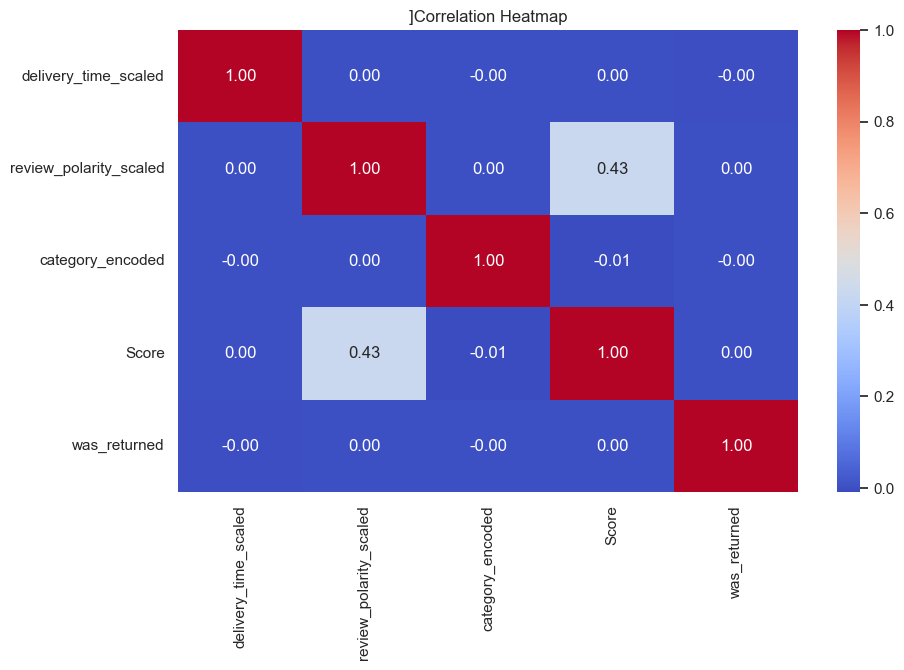

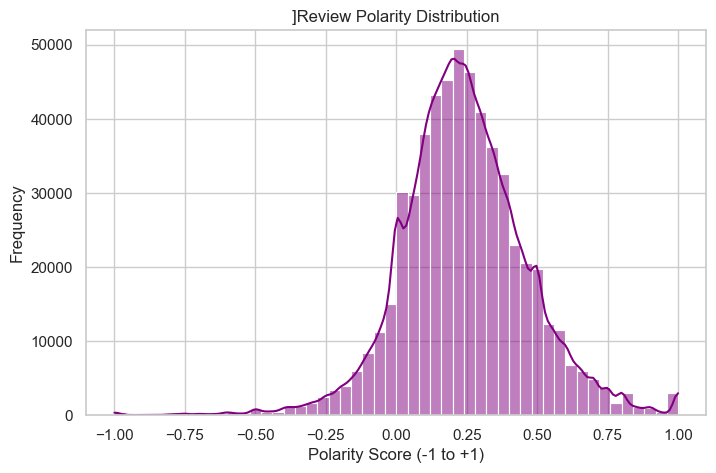

C:\Users\tprit\AppData\Local\Temp\ipykernel_16716\1419816393.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_return.index, y=category_return.values, palette="Set2")


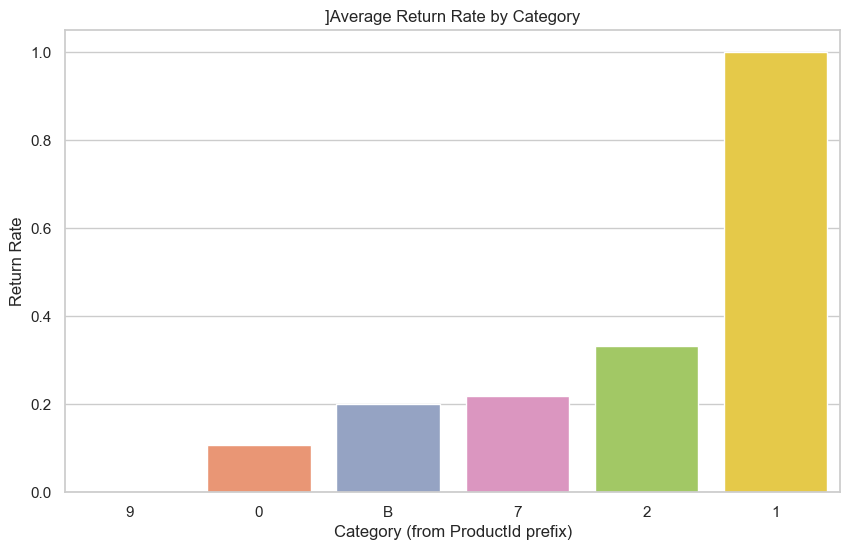

C:\Users\tprit\AppData\Local\Temp\ipykernel_16716\1419816393.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=delivery_return.index, y=delivery_return.values, palette="coolwarm")


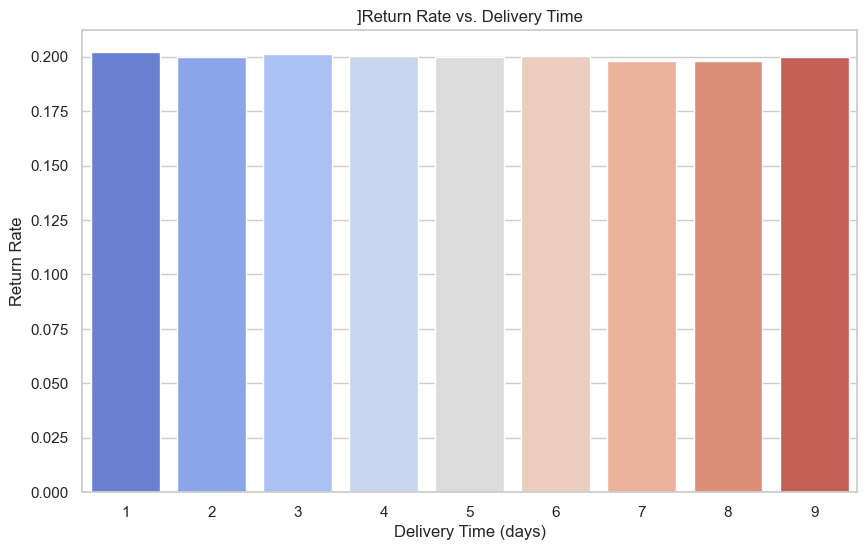

In [13]:

np.random.seed(42)
df['was_returned'] = np.random.choice([0, 1], size=len(df), p=[0.8, 0.2])


plt.figure(figsize=(10, 6))
sns.heatmap(df[['delivery_time_scaled', 'review_polarity_scaled', 'category_encoded', 'Score', 'was_returned']].corr(), 
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title("]Correlation Heatmap")
plt.show()

# Distribution of Review Polarity
plt.figure(figsize=(8, 5))
sns.histplot(df['review_polarity'], bins=50, kde=True, color='purple')
plt.title("]Review Polarity Distribution")
plt.xlabel("Polarity Score (-1 to +1)")
plt.ylabel("Frequency")
plt.show()

# Return Rate by Product Category
plt.figure(figsize=(10, 6))
category_return = df.groupby('category')['was_returned'].mean().sort_values()
sns.barplot(x=category_return.index, y=category_return.values, palette="Set2")
plt.title("]Average Return Rate by Category")
plt.xlabel("Category (from ProductId prefix)")
plt.ylabel("Return Rate")
plt.show()

# Return Rate by Delivery Time
plt.figure(figsize=(10, 6))
delivery_return = df.groupby('delivery_time')['was_returned'].mean().sort_index()
sns.barplot(x=delivery_return.index, y=delivery_return.values, palette="coolwarm")
plt.title("]Return Rate vs. Delivery Time")
plt.xlabel("Delivery Time (days)")
plt.ylabel("Return Rate")
plt.show()


Logistic Regression

In [14]:
# Baseline features (no scaled values)
features_lr = ['delivery_time', 'review_polarity', 'category_encoded', 'Score']
X_lr = df[features_lr]
y = ((df['Score'] <= 2) | (df['review_polarity'] < 0)).astype(int)  # Baseline target

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y, test_size=0.2, random_state=42)


In [15]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_lr, y_train_lr)

y_pred_lr = lr_model.predict(X_test_lr)

print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test_lr, y_pred_lr))
print("AUC Score:", roc_auc_score(y_test_lr, lr_model.predict_proba(X_test_lr)[:, 1]))
print(classification_report(y_test_lr, y_pred_lr, zero_division=0))


Logistic Regression
Accuracy: 0.9450943827736045
AUC Score: 0.983351511045758
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     91759
           1       0.89      0.82      0.85     21927

    accuracy                           0.95    113686
   macro avg       0.92      0.90      0.91    113686
weighted avg       0.94      0.95      0.94    113686



Random Forest Classifier

In [16]:


rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_lr, y_train_lr)

y_pred_rf = rf_model.predict(X_test_lr)

print("Random Forest")
print("Accuracy:", accuracy_score(y_test_lr, y_pred_rf))
print("AUC Score:", roc_auc_score(y_test_lr, rf_model.predict_proba(X_test_lr)[:, 1]))
print(classification_report(y_test_lr, y_pred_rf, zero_division=0))


Random Forest
Accuracy: 1.0
AUC Score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     91759
           1       1.00      1.00      1.00     21927

    accuracy                           1.00    113686
   macro avg       1.00      1.00      1.00    113686
weighted avg       1.00      1.00      1.00    113686



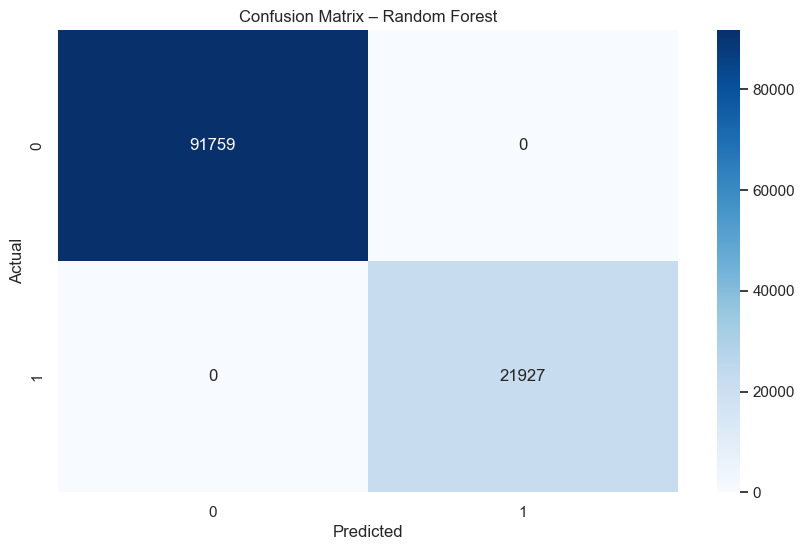

In [17]:
cm_rf = confusion_matrix(y_test_lr, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


XGBoost

In [20]:
# Feature Scaling

# Add additional features
df['helpfulness_ratio'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'].replace(0, np.nan)
df['helpfulness_ratio'].fillna(0, inplace=True)
df['review_length'] = df['Text'].apply(lambda x: len(str(x)))
df['is_high_rating'] = (df['Score'] >= 4).astype(int)

# Scale required features
scaler = StandardScaler()
df[['delivery_time_scaled', 'review_polarity_scaled']] = scaler.fit_transform(df[['delivery_time', 'review_polarity']])


C:\Users\tprit\AppData\Local\Temp\ipykernel_16716\1290783477.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['helpfulness_ratio'].fillna(0, inplace=True)


In [21]:
# Add new features
df['helpfulness_ratio'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'].replace(0, np.nan)
df['helpfulness_ratio'] = df['helpfulness_ratio'].fillna(0)

df['review_length'] = df['Text'].apply(lambda x: len(str(x)))
df['is_high_rating'] = (df['Score'] >= 4).astype(int)

# Feature scaling for delivery_time and review_polarity
scaler = StandardScaler()
df[['delivery_time_scaled', 'review_polarity_scaled']] = scaler.fit_transform(
    df[['delivery_time', 'review_polarity']]
)


In [22]:
final_features = [
    'delivery_time_scaled',
    'review_polarity_scaled',
    'category_encoded',
    'helpfulness_ratio',
    'review_length',
    'is_high_rating'
]

X = df[final_features]
y = ((df['Score'] <= 2) | (df['review_polarity'] < 0)).astype(int)  # Binary target: was_returned

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance
scale = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(f"scale_pos_weight = {scale:.2f}")


scale_pos_weight = 4.19


In [23]:
xgb_model = XGBClassifier(
    scale_pos_weight=scale,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [24]:
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))



Accuracy: 0.9374
AUC Score: 0.9884

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     91759
           1       0.76      1.00      0.86     21927

    accuracy                           0.94    113686
   macro avg       0.88      0.96      0.91    113686
weighted avg       0.95      0.94      0.94    113686



joblib

In [25]:
import joblib
joblib.dump(xgb_model, "return_risk_xgboost_model.pkl")

# Save the scaler too
joblib.dump(scaler, "scaler.pkl")

print("Model and scaler saved successfully!")


Model and scaler saved successfully!


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

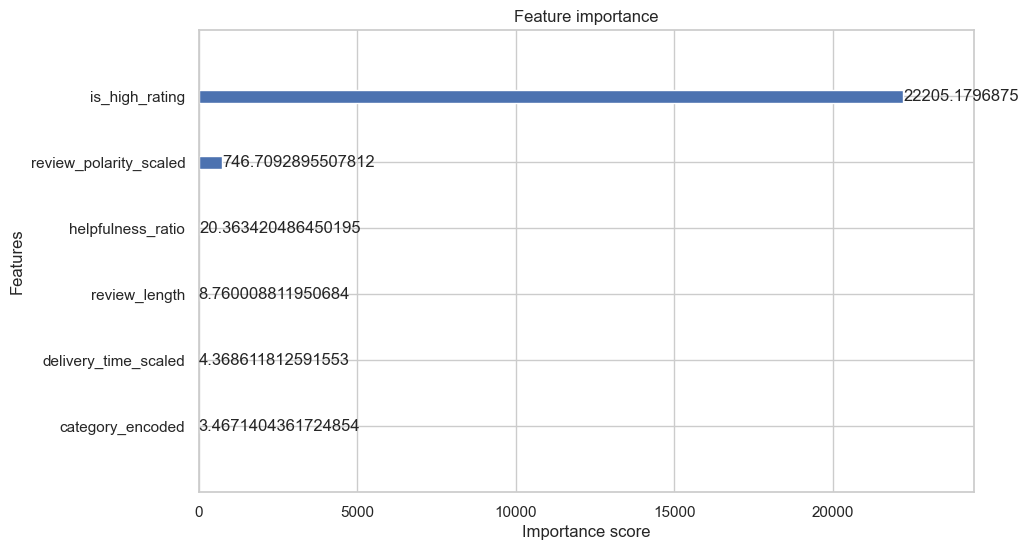

In [26]:
plot_importance(xgb_model, importance_type='gain')
